# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [1]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset)

import seaborn.xkcd_rgb as colors
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("../../")
analysis_name = "cross-validated"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

# we can save plots in this directory
outdir = expandvars("../../plots/")

This cell performs the classification evaluation and should not be modified.

In [4]:
force = True
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_palette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [5]:
color_palette={
    'expected': 'black', 'rdp': colors['baby shit green'], 'sortmerna': colors['macaroni and cheese'],
    'uclust': 'coral', 'blast': 'indigo', 'blast+': colors['electric purple'], 'naive-bayes': 'dodgerblue',
    'naive-bayes-bespoke': 'blue', 'vsearch': 'firebrick'
}

level_results = extract_per_level_accuracy(accuracy_results)

y_vars = ['Precision', 'Recall', 'F-measure']

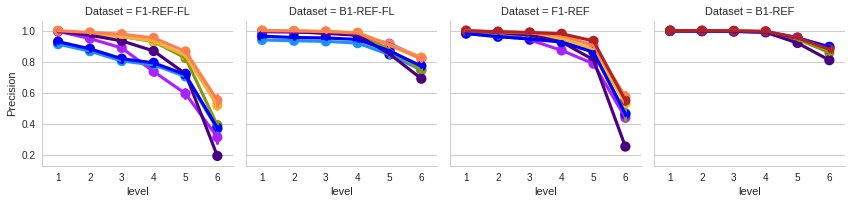

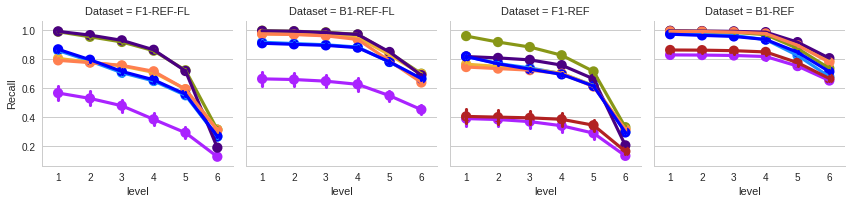

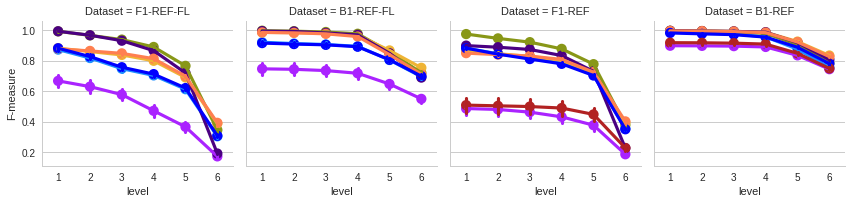

In [6]:
point = pointplot_from_data_frame(level_results, "level", y_vars,
                                  group_by="Dataset", color_by="Method",
                                  color_palette=color_palette)

In [7]:
for k, v in point.items():
    v.savefig(join(outdir, 'cross-val-{0}-lineplots.pdf'.format(k)))

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [8]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

,Dataset,Variable,1,2,3,4,5,6
0,F1-REF-FL,Precision,9.033229e-84,4.932252e-61,2.640063e-70,1.309081e-62,1.703449e-57,1.267542e-74
1,F1-REF-FL,Recall,6.702850e-135,8.291583e-90,1.283373e-76,2.914572e-75,2.918109e-84,1.294745e-53
2,F1-REF-FL,F-measure,1.338238e-121,3.618864e-85,4.075347e-75,9.394210e-76,4.076531e-96,6.528475e-68
3,B1-REF-FL,Precision,2.121709e-67,1.122153e-57,6.519551e-38,4.620913e-27,9.371285e-33,7.818720e-50
4,B1-REF-FL,Recall,1.172918e-91,1.339179e-87,9.644333e-86,1.424603e-90,5.592487e-100,7.585728e-139
5,B1-REF-FL,F-measure,5.590312e-84,1.062676e-77,2.185621e-76,6.191650e-81,1.508837e-104,2.528383e-90
6,F1-REF,Precision,2.914994e-41,2.584764e-43,1.789329e-86,6.978102e-113,6.526361e-96,2.601665e-56
7,F1-REF,Recall,8.418474e-164,4.331661e-130,2.993841e-117,6.239364e-111,4.211015e-117,2.429501e-103
8,F1-REF,F-measure,6.843749e-149,7.013133e-122,1.364713e-112,1.071506e-111,3.789133e-123,2.952317e-103
9,B1-REF,Precision,1.333450e-18,2.098784e-50,1.694184e-40,1.108418e-24,5.608904e-14,7.071744e-21


## Heatmaps of method accuracy by parameter
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal simulated datasets individually).

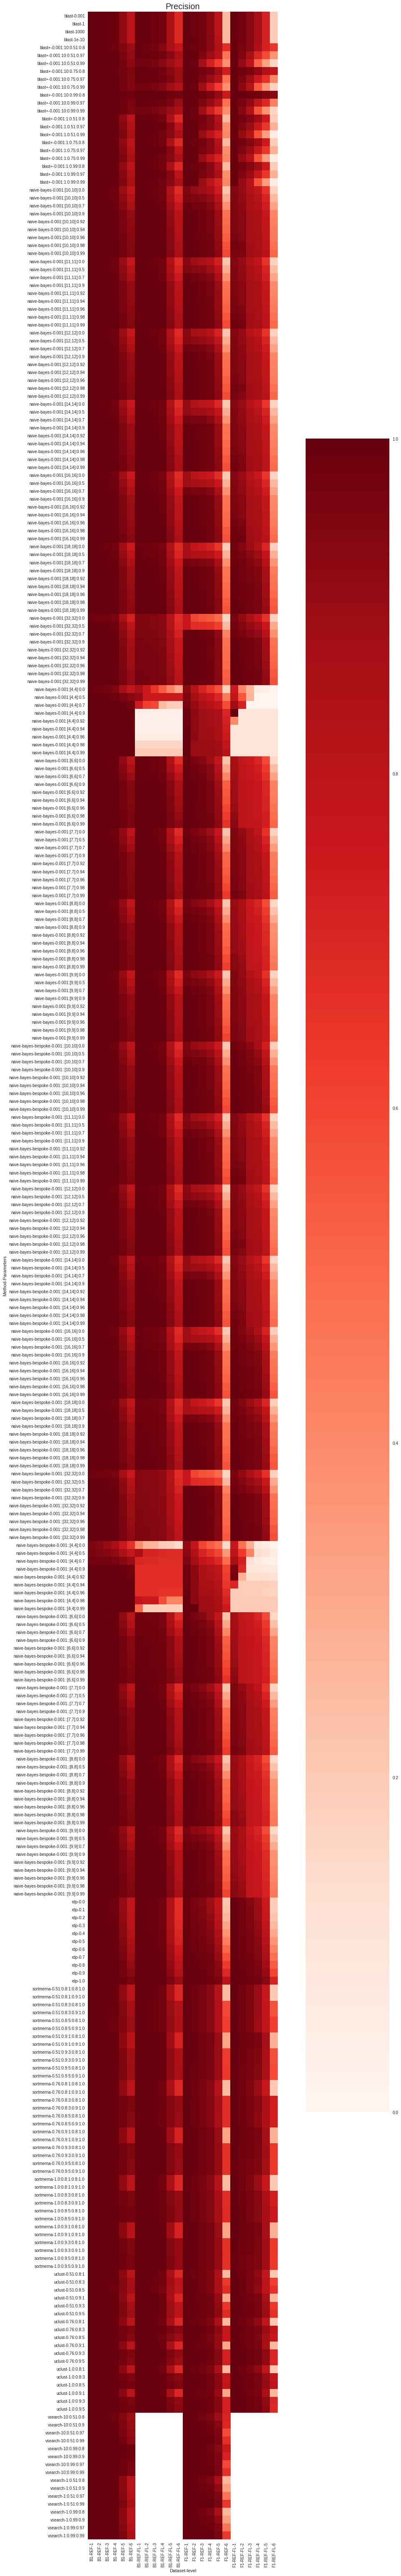

In [9]:
heatmap_from_data_frame(level_results, metric="Precision", rows=["Method", "Parameters"], cols=["Dataset", "level"])

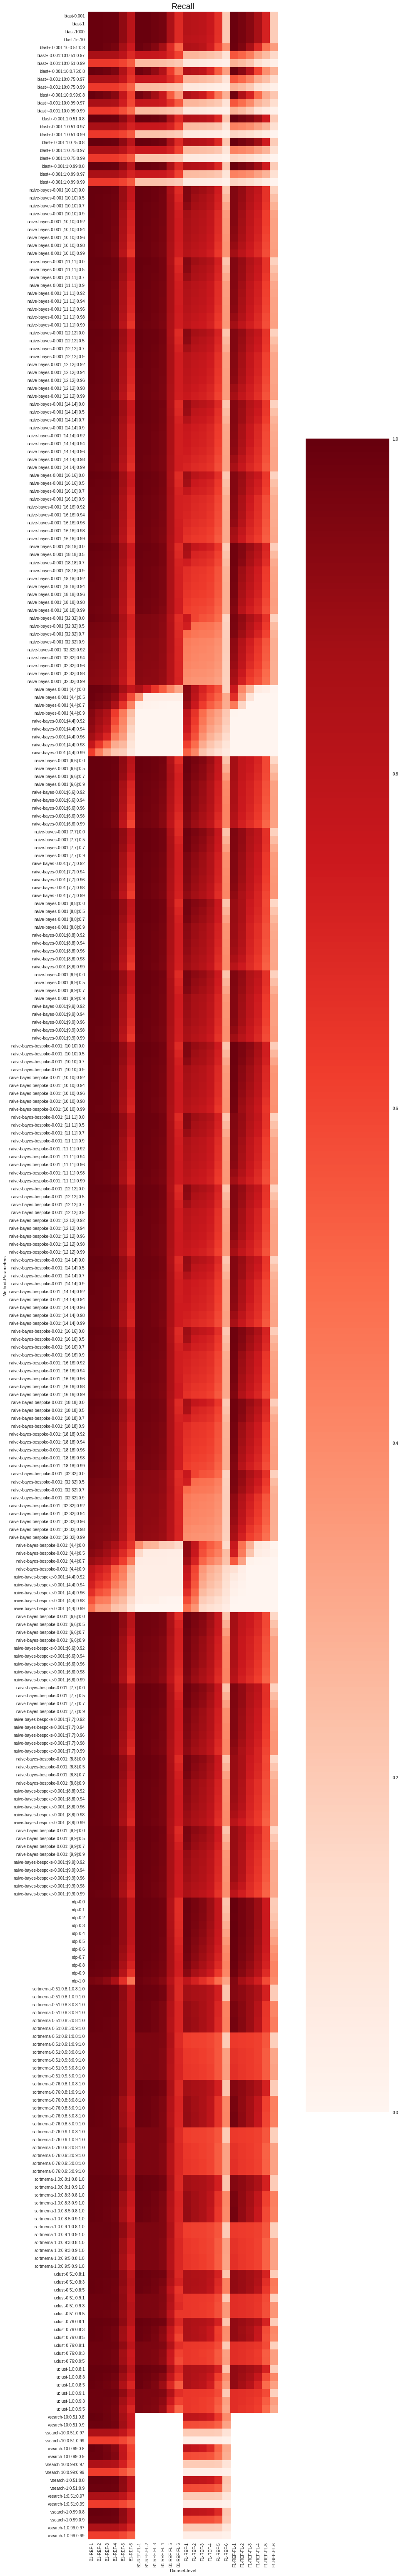

In [10]:
heatmap_from_data_frame(level_results, metric="Recall", rows=["Method", "Parameters"], cols=["Dataset", "level"])

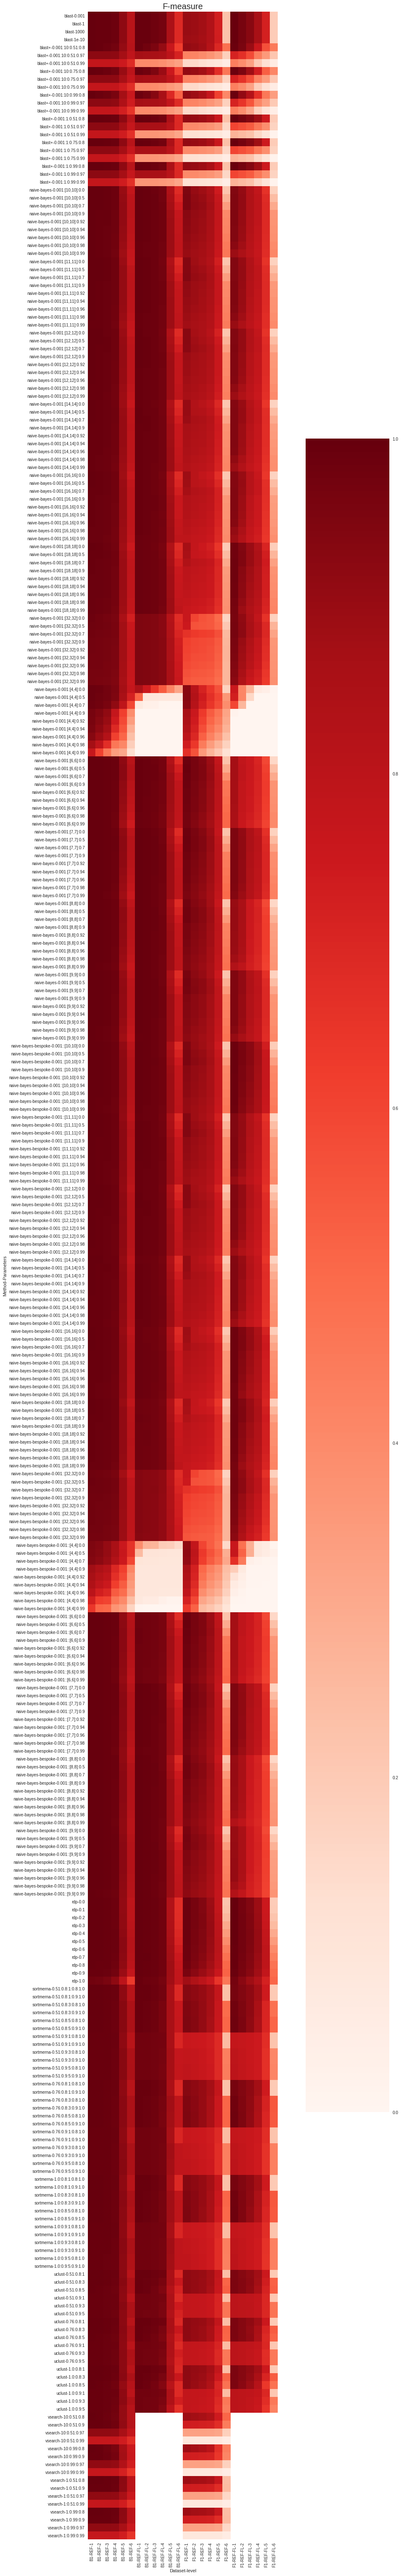

In [11]:
heatmap_from_data_frame(level_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [12]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## blast+

,F-measure,Precision,Recall
0.001:1:0.51:0.8,194.0,164,194.0
0.001:1:0.75:0.8,194.0,164,194.0
0.001:1:0.99:0.8,194.0,164,194.0
0.001:10:0.51:0.8,175.0,160,160.0
0.001:10:0.75:0.8,157.0,199,150.0
0.001:10:0.99:0.8,150.0,230,138.0
0.001:10:0.51:0.97,90.0,158,40.0
0.001:1:0.51:0.97,90.0,163,39.0
0.001:1:0.75:0.97,90.0,163,39.0
0.001:1:0.99:0.97,90.0,163,39.0


## naive-bayes

,F-measure,Precision,Recall
"0.001:[7,7]:0.7",184.0,183,183.0
"0.001:[7,7]:0.9",183.0,193,171.0
"0.001:[7,7]:0.5",182.0,171,183.0
"0.001:[6,6]:0.7",181.0,180,176.0
"0.001:[7,7]:0.92",179.0,194,167.0
"0.001:[6,6]:0.5",178.0,168,176.0
"0.001:[9,9]:0.5",178.0,172,184.0
"0.001:[9,9]:0.7",178.0,185,177.0
"0.001:[10,10]:0.7",177.0,185,173.0
"0.001:[9,9]:0.94",177.0,192,156.0


## rdp

,F-measure,Precision,Recall
0.5,161,172,162
0.6,161,179,160
0.8,161,194,151
0.0,160,160,162
0.1,160,160,162
0.2,160,160,163
0.3,160,160,163
0.4,160,164,163
0.7,160,192,157
0.9,159,197,140


## sortmerna

,F-measure,Precision,Recall
0.51:0.8:1:0.8:1.0,158,160,159
1.0:0.8:1:0.8:1.0,158,160,159
0.51:0.8:1:0.9:1.0,158,160,159
0.76:0.8:1:0.9:1.0,158,160,159
0.76:0.8:1:0.8:1.0,158,160,159
1.0:0.8:1:0.9:1.0,158,160,159
0.51:0.8:3:0.9:1.0,155,160,152
0.51:0.8:3:0.8:1.0,155,160,152
0.76:0.8:3:0.8:1.0,154,179,149
0.76:0.8:5:0.9:1.0,154,174,148


## blast

,F-measure,Precision,Recall
1e-10,162,168,161
0.001,161,167,161
1,161,167,161
1000,161,167,161


## uclust

,F-measure,Precision,Recall
0.51:0.8:3,161,160,161
0.51:0.8:1,160,160,161
1.0:0.8:1,160,160,161
0.51:0.8:5,160,160,160
0.76:0.8:1,160,160,161
0.76:0.8:3,160,200,152
0.76:0.8:5,160,184,150
1.0:0.8:3,160,200,152
1.0:0.8:5,151,217,141
1.0:0.9:3,80,200,80


## naive-bayes-bespoke

,F-measure,Precision,Recall
"0.001::[10,10]:0.92",188.0,191,161.0
"0.001::[10,10]:0.7",187.0,180,181.0
"0.001::[10,10]:0.9",187.0,189,164.0
"0.001::[10,10]:0.94",187.0,194,159.0
"0.001::[10,10]:0.96",186.0,199,155.0
"0.001::[10,10]:0.98",185.0,200,147.0
"0.001::[7,7]:0.7",185.0,180,181.0
"0.001::[7,7]:0.5",184.0,167,182.0
"0.001::[7,7]:0.94",184.0,195,169.0
"0.001::[10,10]:0.5",184.0,171,186.0


## vsearch

,F-measure,Precision,Recall
1:0.51:0.8,100.0,82,100.0
1:0.51:0.9,100.0,90,83.0
1:0.99:0.8,100.0,82,100.0
1:0.99:0.9,100.0,90,83.0
10:0.51:0.9,97.0,90,79.0
10:0.51:0.8,96.0,87,98.0
10:0.99:0.8,90.0,110,80.0
10:0.99:0.9,90.0,110,68.0
1:0.51:0.97,40.0,90,0.0
1:0.99:0.97,40.0,90,0.0


## Rank performance of optimized methods
Now we rank the top-performing method/parameter combination for each method at genus and species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## F1-REF-FL level 6

,Method,Parameters,Precision,Recall,F-measure
5,sortmerna,1.0:0.8:3:0.9:1.0,0.733781,0.437475,0.547999
6,uclust,1.0:0.8:3,0.789000,0.406528,0.536387
4,rdp,1.0,0.715778,0.396692,0.510271
3,naive-bayes-bespoke,"0.001::[10,10]:0.99",0.567755,0.382410,0.456894
1,blast+,0.001:10:0.51:0.8,0.647144,0.347052,0.451737
2,naive-bayes,"0.001:[7,7]:0.99",0.534157,0.363603,0.432576
0,blast,0.001,0.192208,0.191251,0.191728


stat             P         FDR P
Method A    Method B                                                  
blast+      naive-bayes           0.378291  7.139830e-01  7.407133e-01
            rdp                  -5.577752  3.439416e-04  6.566158e-04
            sortmerna           -11.876930  8.406206e-07  2.942172e-06
            blast                24.481136  1.516710e-09  6.370181e-09
            uclust              -11.136114  1.451218e-06  4.353655e-06
            naive-bayes-bespoke  -0.341297  7.407133e-01  7.407133e-01
naive-bayes rdp                  -1.632274  1.370568e-01  1.598996e-01
            sortmerna            -2.278349  4.869374e-02  6.817124e-02
            blast                 4.934104  8.087645e-04  1.415338e-03
            uclust               -2.071753  6.817015e-02  8.657598e-02
            naive-bayes-bespoke  -0.469303  6.500146e-01  7.184371e-01
rdp         sortmerna            -4.268942  2.083553e-03  3.365739e-03
            blast                99.989330  5.077960e-15  1.066372e-13
            uclust               -3.849463  3.909521e-03  5.864282e-03
            naive-bayes-bespoke   5.870449  2.376320e-04  4.990271e-04
sortmerna   blast                37.045466  3.772605e-11  2.640824e-10
            uclust                2.054642  7.008532e-02  8.657598e-02
            naive-bayes-bespoke   7.024022  6.159426e-05  1.616849e-04
blast       uclust              -41.380086  1.400987e-11  1.471037e-10
            naive-bayes-bespoke -26.987792  6.375927e-10  3.347362e-09
uclust      naive-bayes-bespoke   6.303809  1.403477e-04  3.274780e-04

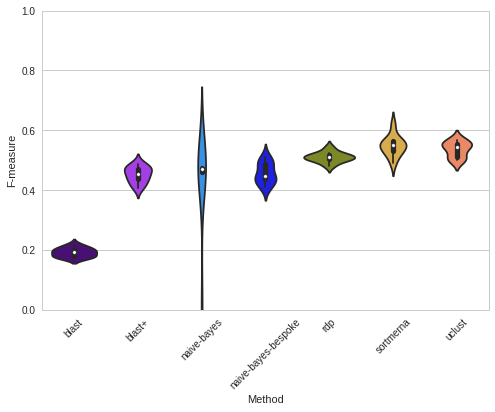

## B1-REF-FL level 6

,Method,Parameters,Precision,Recall,F-measure
3,naive-bayes-bespoke,"0.001::[7,7]:0.99",0.887093,0.731917,0.801944
2,naive-bayes,"0.001:[8,8]:0.99",0.875116,0.730136,0.795963
5,sortmerna,1.0:0.8:3:0.9:1.0,0.906514,0.704424,0.792723
4,rdp,1.0,0.898980,0.694428,0.783525
6,uclust,0.76:0.8:3,0.930516,0.644916,0.761717
1,blast+,0.001:10:0.51:0.97,0.860250,0.608431,0.712609
0,blast,0.001,0.690227,0.689875,0.690051


stat             P         FDR P
Method A    Method B                                                  
blast+      naive-bayes         -17.327071  3.205212e-08  3.365473e-07
            rdp                 -10.972760  1.643943e-06  4.931830e-06
            sortmerna           -10.650259  2.113000e-06  5.546625e-06
            blast                 4.164762  2.430455e-03  3.645682e-03
            uclust               -6.048626  1.908061e-04  3.642661e-04
            naive-bayes-bespoke -12.408781  5.785547e-07  2.024941e-06
naive-bayes rdp                   2.910768  1.728962e-02  2.135776e-02
            sortmerna             0.522497  6.139409e-01  6.139409e-01
            blast                19.120295  1.349597e-08  2.834153e-07
            uclust                4.668026  1.171854e-03  1.892994e-03
            naive-bayes-bespoke  -1.819007  1.022642e-01  1.130288e-01
rdp         sortmerna            -2.203965  5.498387e-02  6.414785e-02
            blast                15.186389  1.013323e-07  5.319944e-07
            uclust                4.010721  3.060550e-03  4.264796e-03
            naive-bayes-bespoke  -3.971072  3.249368e-03  4.264796e-03
sortmerna   blast                16.312754  5.432712e-08  3.802898e-07
            uclust                9.326497  6.373178e-06  1.338367e-05
            naive-bayes-bespoke  -1.399689  1.951188e-01  2.048748e-01
blast       uclust               -9.717085  4.541389e-06  1.059657e-05
            naive-bayes-bespoke -14.432024  1.576687e-07  6.622087e-07
uclust      naive-bayes-bespoke  -5.492155  3.840665e-04  6.721164e-04

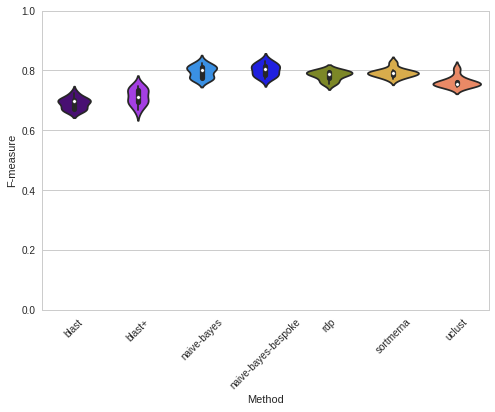

## F1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
6,uclust,0.51:0.8:5,0.684296,0.429991,0.528025
4,rdp,0.9,0.697787,0.411087,0.517324
3,naive-bayes-bespoke,"0.001::[6,6]:0.99",0.653155,0.422298,0.512867
5,sortmerna,0.76:0.8:5:0.9:1.0,0.673183,0.412841,0.511767
2,naive-bayes,"0.001:[6,6]:0.99",0.655488,0.419046,0.511161
7,vsearch,10:0.51:0.8,0.705452,0.397744,0.508549
1,blast+,0.001:10:0.51:0.8,0.671470,0.378932,0.484280
0,blast,1e-10,0.255774,0.206764,0.228650


stat             P         FDR P
Method A    Method B                                                  
blast+      naive-bayes          -4.673727  1.162454e-03  2.324909e-03
            vsearch              -9.421093  5.864727e-06  1.824582e-05
            rdp                  -5.851767  2.432225e-04  6.191119e-04
            sortmerna            -7.762333  2.814248e-05  7.879894e-05
            blast                30.947561  1.881978e-10  7.527912e-10
            uclust              -14.520262  1.495592e-07  5.234573e-07
            naive-bayes-bespoke  -5.208140  5.579570e-04  1.301900e-03
naive-bayes vsearch               0.605364  5.598905e-01  6.029590e-01
            rdp                  -1.074151  3.107085e-01  3.793092e-01
            sortmerna            -0.115035  9.109433e-01  9.109433e-01
            blast                43.485879  8.980502e-12  8.381802e-11
            uclust               -2.445055  3.705609e-02  6.484816e-02
            naive-bayes-bespoke  -1.107819  2.966667e-01  3.793092e-01
vsearch     rdp                  -1.588344  1.466713e-01  2.161472e-01
            sortmerna            -0.827187  4.295167e-01  4.810587e-01
            blast                36.292970  4.532830e-11  2.285477e-10
            uclust               -4.998257  7.407280e-04  1.595414e-03
            naive-bayes-bespoke  -1.127807  2.885688e-01  3.793092e-01
rdp         sortmerna             1.072111  3.115754e-01  3.793092e-01
            blast                53.546691  1.389022e-12  3.889260e-11
            uclust               -1.908000  8.874521e-02  1.380481e-01
            naive-bayes-bespoke   0.904331  3.893849e-01  4.542824e-01
sortmerna   blast                36.874644  3.931868e-11  2.285477e-10
            uclust               -3.147397  1.178682e-02  2.200207e-02
            naive-bayes-bespoke  -0.209640  8.386170e-01  8.696769e-01
blast       uclust              -35.980379  4.897450e-11  2.285477e-10
            naive-bayes-bespoke -44.680526  7.043922e-12  8.381802e-11
uclust      naive-bayes-bespoke   2.361189  4.251842e-02  7.003034e-02

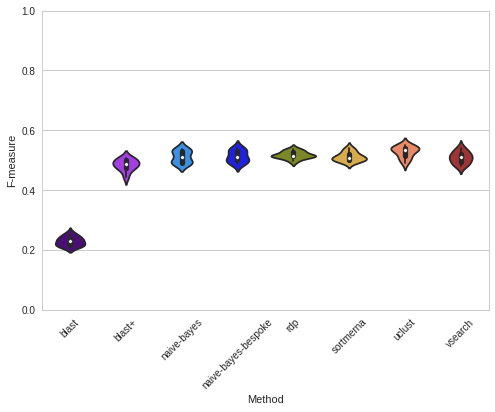

## B1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
5,sortmerna,0.76:0.8:5:0.9:1.0,0.934980,0.781390,0.851284
6,uclust,0.51:0.8:3,0.873325,0.822354,0.847064
3,naive-bayes-bespoke,"0.001::[6,6]:0.7",0.884186,0.786815,0.832653
2,naive-bayes,"0.001:[6,6]:0.7",0.900455,0.765003,0.827215
7,vsearch,10:0.51:0.9,0.896329,0.755438,0.819837
4,rdp,0.5,0.847648,0.787429,0.816427
1,blast+,0.001:10:0.51:0.8,0.896382,0.749011,0.816035
0,blast,1e-10,0.809746,0.807025,0.808383


stat             P         FDR P
Method A    Method B                                                  
blast+      naive-bayes          -3.413447  7.707449e-03  9.809480e-03
            vsearch              -3.265361  9.754774e-03  1.187538e-02
            rdp                  -0.119500  9.075042e-01  9.075042e-01
            sortmerna           -15.306849  9.460483e-08  2.943261e-07
            blast                 2.164396  5.864626e-02  6.315751e-02
            uclust               -9.680066  4.687291e-06  9.515191e-06
            naive-bayes-bespoke  -6.737585  8.483442e-05  1.319646e-04
naive-bayes vsearch               2.421682  3.850425e-02  4.492162e-02
            rdp                   9.033938  8.279083e-06  1.448839e-05
            sortmerna           -10.652090  2.109952e-06  5.907866e-06
            blast                19.515871  1.126881e-08  7.888169e-08
            uclust              -17.015659  3.756941e-08  1.952261e-07
            naive-bayes-bespoke  -3.423904  7.580973e-03  9.809480e-03
vsearch     rdp                   1.214379  2.555041e-01  2.649672e-01
            sortmerna           -16.796992  4.207132e-08  1.952261e-07
            blast                 3.781383  4.339772e-03  6.075681e-03
            uclust               -9.453657  5.700168e-06  1.064031e-05
            naive-bayes-bespoke  -5.952329  2.147231e-04  3.164341e-04
rdp         sortmerna           -16.514100  4.880652e-08  1.952261e-07
            blast                 8.961748  8.840670e-06  1.456110e-05
            uclust              -21.114242  5.625700e-09  7.875980e-08
            naive-bayes-bespoke  -9.662679  4.757596e-06  9.515191e-06
sortmerna   blast                20.031778  8.953263e-09  7.888169e-08
            uclust                2.183154  5.688143e-02  6.315751e-02
            naive-bayes-bespoke   9.864858  4.006863e-06  9.349346e-06
blast       uclust              -30.420608  2.193630e-10  6.142165e-09
            naive-bayes-bespoke -15.624536  7.911704e-08  2.769096e-07
uclust      naive-bayes-bespoke   9.868633  3.994149e-06  9.349346e-06

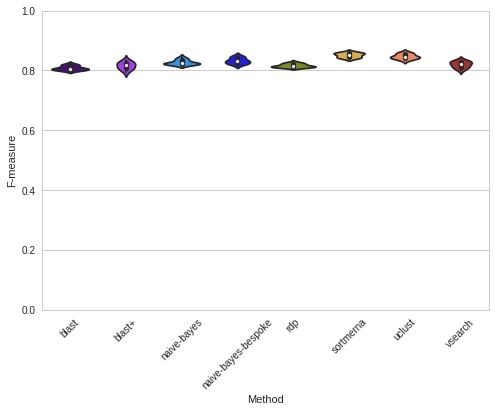

In [13]:
boxes = rank_optimized_method_performance_by_dataset(level_results,
                                                     metric="F-measure",
                                                     level="level",
                                                     level_range=range(6,7),
                                                     display_fields=["Method",
                                                                     "Parameters",
                                                                     "Precision",
                                                                     "Recall",
                                                                     "F-measure"],
                                                     paired=True,
                                                     parametric=True,
                                                     color=None,
                                                     color_palette=color_palette)

In [14]:
for k, v in boxes.items():
    v.get_figure().savefig(join(outdir, 'cross-val-{0}-boxplots.pdf'.format(k)))